In [35]:
import numpy as np
# from GAIndividual import GAIndividual
import random
import copy
import matplotlib.pyplot as plt

class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
        self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
        self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print("Optimal solution is:")
        print("m1--m2--m3--m4--m5--m6--mspend--mbid")
        print(self.best.chrom)
        self.printResult()
        return self.best.chrom
    
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] + \
                        (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()


In [3]:
import numpy as np
# import ObjFunction


class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = ObjectiveFunc.fitness_function( self.chrom, df )

In [31]:

import pandas as pd
import conversion_index_collector
        
class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''
    def __init__(self, campaign_id=None):
        self.mydb = conversion_index_collector.connectDB( "dev_facebook_test" )
        
    def fitness_function(optimal_weight, df):
        
        m1 = df['purchase'] / df['initiate_checkout']
        m2 = df['initiate_checkout'] / df['add_to_cart']
        m3 = df['add_to_cart'] / df['view_content']
        m4 = df['view_content'] / df['landing_page_view']
        m5 = df['landing_page_view'] / df['link_click']
        m6 = df['link_click'] / df['impressions']
        m_spend = -( df['daily_budget'] - df['spend'] ) / df['daily_budget']
        m_bid   = ( df['campaign_bid'] - df['cost_per_purchase'] ) / df['campaign_bid']
        
        
        
#         m_kpi   = df['campaign_target'] / df['daily_charge']
#         m_spend = -( df['daily_budget'] - df['spend'] ) / df['daily_budget']
#         m_bid   = ( df['campaign_bid'] - df['campaign_cost_per_target'] ) / df['campaign_bid']
#         m_width = df['impressions'] / df['daily_budget']
#         m_ctr   = ctr/target_ctr 

        status  = np.array( [m1, m2, m3, m4, m5, m6, m_spend, m_bid] )
#         status  = np.array( [m_kpi, m_spend, m_bid, m_width] )
        r = np.dot( optimal_weight, status )
        return r

    def adset_fitness(optimal_weight, df):
        m_kpi   = df['target'] / df['daily_charge'] * 10
        if df['target'].iloc[0] == 0:
            m_kpi = -10
        m_spend = -( df['daily_budget'] - df['spend'] ) / df['daily_budget']
        m_bid   = ( df['bid_amount'] - df['cost_per_target'] ) / df['bid_amount']
    #     m_width = df['impressions'] / df['daily_budget']
        status  = np.array( [m_kpi, m_spend, m_bid] )
        optimal_weight = np.array([optimal_weight['weight_kpi'].iloc[0], optimal_weight['weight_spend'].iloc[0], optimal_weight['weight_bid'].iloc[0]])
        r = np.dot( optimal_weight, status )
#         print(status)
#         print(optimal_weight)
        return r  

    def account_status( self, campaign_id ):
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        df_camp['daily_charge'] = df_camp['target']/df_camp['period']
        df_camp['campaign_bid'] = df_camp['spend_cap']/df_camp['target']
        charge_type = df_camp['charge_type'].iloc[0]
        acc_id = facebook_datacollector.Campaigns(campaign_id, charge_type).get_account_id()
        insights = facebook_datacollector.Accounts( "act_"+ str(acc_id) ).get_account_insights()
        for insight in insights:
            spend = int( insight.get("spend") )
            account_cpc = float( insight.get("cpc") )
            account_charge = int( insight.get("clicks") )
            impressions = int( insight.get("impressions") )
        df=pd.DataFrame(
            {
                'campaign_id':[campaign_id],
                'campaign_cost_per_target':[account_cpc],
                'campaign_target':[account_charge],
                'impressions':[impressions],
                'campaign_bid':[df_camp['campaign_bid'].iloc[0]],
                'spend':[spend],
                'daily_budget':[df_camp['daily_budget'].iloc[0]],
                'daily_charge':[df_camp['daily_charge'].iloc[0]],
                'daily_budget':[df_camp['daily_budget'].iloc[0]]
            }
        )
        df = df.convert_objects(convert_numeric=True)
        return df
    
    def campaign_status( self, campaign_id ):
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        df_metrics = pd.read_sql("SELECT * FROM campaign_conversion_metrics WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        df_camp['campaign_bid'] = df_camp['spend_cap']/df_camp['target']
        self.charge_type = df_camp['charge_type'].iloc[0]

        spend = df_camp['spend'].iloc[0]
        campaign_cost_per_target = df_camp['cost_per_target'].iloc[0]
        campaign_target = df_camp['target'].iloc[0]
        impressions = df_camp['impressions'].iloc[0]
        df=pd.DataFrame(
            {
                'campaign_id':[ campaign_id ],
                'campaign_cost_per_target':[ campaign_cost_per_target ],
                'campaign_target':[ campaign_target ],
#                 'impressions':[ impressions ],
#                 'spend':[ spend ],
                'campaign_bid':[ df_camp['campaign_bid'].iloc[0] ],
                'daily_budget':[ df_camp['daily_budget'].iloc[0] ]
            }
        )
        df = pd.merge( df, df_metrics, on=['campaign_id'] )
        df = df.convert_objects(convert_numeric=True)
        return df
    
    def adset_status( self, adset_id ):
        df=pd.DataFrame({'adset_id':[],'target':[], 'impressions':[], 'bid_amount':[]})

        df_adset = pd.read_sql("SELECT * FROM adset_insights WHERE adset_id=%s ORDER BY request_time DESC LIMIT 1" %(adset_id), con=self.mydb)
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s" %(df_adset['campaign_id'].iloc[0]), con=self.mydb)
#         df_camp['daily_charge'] = df_camp['target']/df_camp['campaign_days']
        df_temp = pd.merge( df_adset[['campaign_id', 'adset_id', 'target', 'cost_per_target', 'impressions']],
                              df_adset[['adset_id','spend','bid_amount','daily_budget']],
                              on=['adset_id'] )
        df_camp['campaign_daily_budget'] = df_camp['daily_budget']
        df_status = pd.merge( df_temp,
                              df_camp[['campaign_id', 'daily_charge', 'campaign_daily_budget']],
                              on=['campaign_id'] )
        df = pd.concat([df, df_status], ignore_index=True, sort=True)
#         print(ad_id)
#         print(df[['adset_id', 'charge', 'charge_cpc','bid_amount', 'impressions', 'spend']])
        return df

In [24]:
ObjectiveFunc().campaign_status(23843269222010540).columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Index(['campaign_id', 'campaign_cost_per_target', 'campaign_target',
       'campaign_bid', 'daily_budget', 'add_to_cart', 'initiate_checkout',
       'purchase', 'view_content', 'landing_page_view', 'link_click',
       'impressions', 'cost_per_purchase', 'cost_per_add_to_cart',
       'cost_per_initiate_checkout', 'cost_per_view_content',
       'cost_per_landing_page_view', 'cost_per_link_click', 'spend'],
      dtype='object')

In [5]:

def ga_optimal_weight(campaign_id):
    request_time = datetime.datetime.now().date()
    mydb = mysql_adactivity_save.connectDB( "Facebook" )
    df_weight = pd.read_sql("SELECT * FROM optimal_weight WHERE campaign_id=%s " %(campaign_id), con=mydb)
    df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s " %(campaign_id), con=mydb)
    charge_type = df_camp['charge_type'].iloc[0]
    adset_list = facebook_datacollector.Campaigns(campaign_id, charge_type).get_adsets()
    for adset_id in adset_list:
        
#         print(ad_id)
        df = ObjectiveFunc.adset_status( adset_id )
        r = ObjectiveFunc.adset_fitness( df_weight, df )
#         print('[score]', r, ad_id)

        df_final = pd.DataFrame({'campaign_id':campaign_id, 'adset_id':adset_id, 'score':r, 'request_time':request_time}, index=[0])

        mysql_adactivity_save.intoDB("adset_score", df_final)

In [52]:
sizepop, vardim, MAXGEN, params = 2000, 8, 30, [0.9, 0.1, 0.5]

In [ ]:
%%time
campaign_list = mysql_adactivity_save.get_campaign()
for camp_id in campaign_list:
#         ga_optimal_weight(camp_id)
    print('campaign_id:', camp_id )
    global df
    df = ObjectiveFunc(camp_id).campaign_status()
    bound = np.tile([[0], [1]], vardim)
    ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
    optimal = ga.solve()
    score = ObjectiveFunc.fitnessfunc(optimal, df)

    score_columns=['weight_kpi', 'weight_spend', 'weight_bid']
    df_score = pd.DataFrame(data=[optimal], columns=['weight_kpi', 'weight_spend', 'weight_bid'], index=[0])
#         score_columns=['weight_kpi', 'weight_spend', 'weight_bid', 'weight_width']
#         df_score = pd.DataFrame(data=[optimal], columns=['weight_kpi', 'weight_spend', 'weight_bid', 'weight_width'], index=[0])        

    df_final = pd.DataFrame({'campaign_id':camp_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
    df_final = pd.concat( [df_score, df_final], axis=1, sort=True, ignore_index=False)
    mysql_adactivity_save.check_optimal_weight(camp_id, df_final)
    ga_optimal_weight(camp_id)

    print('optimal_weight:', optimal)

In [7]:
campaign_objective = {
    'LINK_CLICKS': 'link_click',
    'POST_ENGAGEMENT': 'post_engagement', 
    'VIDEO_VIEWS': 'video_view', 
    'CONVERSIONS':'offsite_conversion.fb_pixel_purchase',
    'APP_INSTALLS': 'app_installs',
    'BRAND_AWARENESS': 'brand_awareness',
    'EVENT_RESPONSES': 'event_responses',
    'LEAD_GENERATION': 'lead_generation',
    'LOCAL_AWARENESS': 'local_awareness',
    'MESSAGES': 'messages',
    'OFFER_CLAIMS': 'offer_claims',
    'PAGE_LIKES': 'page_likes',
    'PRODUCT_CATALOG_SALES': 'product_catalog_sales',
    'REACH': 'reach',
    'ALL_CLICKS': 'clicks',
}

In [ ]:
# from tabulate import tabulate
# campaign_list = mysql_adactivity_save.get_campaign()
# for camp in campaign_list:
df_camp = mysql_adactivity_save.get_campaign_target(23843269222010540)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Generation 0: optimal function value is: -0.988952; average function value is -0.979840
Generation 1: optimal function value is: 90.513863; average function value is 57.665255
Generation 2: optimal function value is: 90.513863; average function value is 61.820860
Generation 3: optimal function value is: 90.513863; average function value is 63.977276
Generation 4: optimal function value is: 90.513863; average function value is 65.496933
Generation 5: optimal function value is: 90.513863; average function value is 66.623137
Generation 6: optimal function value is: 90.513863; average function value is 67.149812
Generation 7: optimal function value is: 90.513863; average function value is 67.601081
Generation 8: optimal function value is: 90.513863; average function value is 67.908868
Generation 9: optimal function value is: 90.513863; average function value is 68.081890
Generation 10: optimal function value is: 90.513863; average function value is 68.352657
Generation 11: optimal function

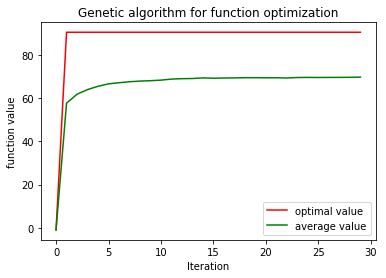

CPU times: user 4min 31s, sys: 4.01 ms, total: 4min 31s
Wall time: 4min 32s


In [53]:
%%time
global df
df = ObjectiveFunc().campaign_status(23843269222010540)
bound = np.tile([[0], [10]], vardim)
ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
optimal = ga.solve()
score = ObjectiveFunc.fitness_function(optimal, df)
score

In [58]:
df = ObjectiveFunc().campaign_status(23843269222010540)
for opt in opt_list:
    score = ObjectiveFunc.fitness_function(opt, df)
    print(score)

[88.94458878]
[91.46444673]
[88.82323198]
[90.51386341]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
